<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installations

In [ ]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

  Cloning https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to /tmp/pip-req-build-vn0snmkt
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 /tmp/pip-req-build-vn0snmkt
  Resolved https://github.com/CLAIR-LAB-TECHNION/ICAPS-24 to commit 50d41a6a9260da395e96f66227fed82fa1fcba74
  Preparing metadata (setup.py) ... done


In [ ]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

## Imports

In [ ]:
import mediapy as media
import numpy as np
from numpy import pi

# Introduction to continuous N table blocks World

In [ ]:
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()
print(state)

{'robot_joint_pos': array([ 4.36254124e-05, -1.57031639e+00,  1.44185993e-04,  1.00867864e-04,
       -1.38248476e-05,  9.96726376e-09]), 'robot_joint_velocities': array([ 3.32137057e-03, -1.37949741e-02, -4.05636768e-03,  1.34886132e-02,
       -1.87691326e-03, -3.28900405e-06]), 'gripper_state_closed': False, 'object_positions': {'block 1 red': array([-0.1       ,  0.55      ,  0.72986352]), 'block 2 yellow': array([0.1       , 0.5       , 0.72986352]), 'block 3 cyan': array([0.2       , 0.63      , 0.72986352]), 'block 4 purple': array([0.24      , 0.39      , 0.72986352]), 'block 5 red': array([-0.2       , -0.52      ,  0.72986352]), 'block 6 yellow': array([ 0.1       , -0.51      ,  0.72986352]), 'block 7 cyan': array([-0.07      , -0.65      ,  0.72986352]), 'block 8 purple': array([-0.1       , -0.4       ,  0.72986352]), 'block 9 red': array([6.00000000e-01, 4.44089210e-20, 7.29761806e-01]), 'block 10 yellow': array([ 6.00000000e-01, -1.77635684e-20,  7.60335562e-01])}}


""

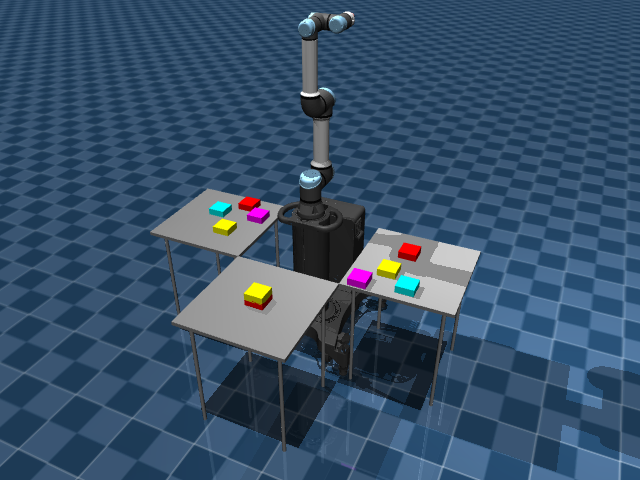

In [ ]:
im = env.render()
media.show_image(im)

In [ ]:
%%script false --no-raise-error

framerate = 60
frames = []

state = env.reset()

# move to all joints at -45 degrees, for 100 steps:
action = [-pi/4]*6
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# move to another config for 100 steps:
action = [0, -pi/2, pi/2, 0, 0, 0]
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

From now and on, to reduce runtime, let's not render after every step, but every 8 steps. We can change it when we want better looking videos.

Here we implement a convenience function, that moves the robot to a desired config. We can use it instead of rewriting the loop every time. It can also be set to stop automatically when reaching the desiried config, and when the robot joints velocity is low enough.
This method also create frames for video, in a desired frequency.

In [ ]:
def move_to(env, target_config, tolerance=0.05, end_vel=0.1, max_steps=None,
            render_freq=8):
    '''
    move robot joints to target config, until it is close within tolerance,
    or max_steps exceeded.
    @param target_joint_pos: position to move to
    @param tolerance: distance withing configuration space to target to consider
     as reached
    @param max_steps: maximum steps to take before stopping, no limit if None
    @param render_freq: how often to render and append a frame
    @return: success, frames
    '''
    joint_positions = env.robot_joint_pos
    joint_velocities = env.robot_joint_velocities

    frames = []

    i = 0
    while np.linalg.norm(joint_positions - target_config) > tolerance \
    or np.linalg.norm(joint_velocities) > end_vel:
        if max_steps is not None and i > max_steps:
            return False, frames

        state = env.step(target_config)
        joint_positions = state['robot_joint_pos']
        joint_velocities = state['robot_joint_velocities']

        if i % render_freq == 0:
            frames.append(env.render())

        i += 1

    return True, frames

In [ ]:
framerate = 8
render_freq = 8

env.reset()

config1 = [-pi/4]*6
success, frames1 = move_to(env, config1)

config2 = [0, -pi/2, pi/2, 0, 0, 0]
success, frames2 = move_to(env, config2)

frames = np.concatenate([frames1, frames2])

# show video:
media.show_video(frames, fps=framerate)

## Exercise
Try to move the end effector of the robotic arm to be above the yellow block that is on the right table. complete the code in the following cell:

In [ ]:
%%script false --no-raise-error

# choose a config that will bring the end effector to be above the yellow
# block that is on the right table. This configuration will be used as an action
above_right_yellow_block = # TODO - your code here

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

In [ ]:
# proposed solution:
above_right_yellow_block = [-0.6, -0.6, 1.7, 0.7, pi/2, 0]

success, frames = move_to(env, above_right_yellow_block)
media.show_video(frames, fps=framerate)

## moving to position with inverse kinematics

let's extract the cartesian coordinates of the yellow block, and set a target position for the robot end effector, which is 10 centimeters above the block to be able to grasp it.

In [ ]:
object_positions = state['object_positions']
target_position = object_positions['block 2 yellow']
target_position[2] += 0.1  # add 10 centimeters to Z axis
print("target position:", target_position)

target position: [0.1        0.5        0.82978449]


We also need to choose target orientation of the end effector. We want it to face down to pick up blocks, we provide target orientation as a rotation matrix.

In [ ]:
facing_down_R = [[0, 0, -1],
                 [0, 1, 0],
                 [1, 0, 0]]

We have created a motion planning utility class that implements inverse kinematics, and other methods that we will use and explain about later. Let's use it to find an inverse kinematic solution where the end effector is facing down, and is above the yellow box:

In [ ]:
from motion_planning.motion_planner import NTableBlocksWorldMotionPlanner

motion_planner = NTableBlocksWorldMotionPlanner()
above_yellow_block_config = motion_planner.ik_solve(goal_pos=target_position,
                                                    goal_R=facing_down_R,)
print(above_yellow_block_config)


[-0.4131408385184721, -0.5865607674475697, 2.0310102286732468, -3.015249693832631, -1.5707967637222915, 1.1576553405662686]URDFParser: Link size: 10
URDFParser: Joint size: 10
Geometry: Loading 2 meshes from /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/meshes/ur5/visual/base.dae into Group
Geometry: Loading 3 meshes from /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/meshes/ur5/visual/shoulder.dae into Group
Geometry: Loading 7 meshes from /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/meshes/ur5/visual/upperarm.dae into Group
ManagedGeometry: loaded /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/meshes/ur5/visual/upperarm.dae in time 0.248051s
Geometry: Loading 4 meshes from /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/meshes/ur5/visual/forearm.dae into Group
Geometry: Loading 3 meshes from /usr/local/lib/python3.10/dist-packages/motion_planning/ur_description/me

Let's test this solution:

In [ ]:
env.reset()
success, frames = move_to(env, above_yellow_block_config, max_steps=200)
media.show_video(frames, fps=framerate)

### moving a block

In [ ]:
drop_position = object_positions['block 8 purple']
drop_position[2] += 0.1
above_purple_block_config = motion_planner.ik_solve(goal_pos=drop_position,
                                                    goal_R=facing_down_R,)

env.set_gripper(True)
success, frames = move_to(env, above_purple_block_config, max_steps=100)
env.set_gripper(False)

media.show_video(frames, fps=framerate)


no ik solution found


In [ ]:

# above_yellow_block_config, drop_position

trajectory = motion_planner.plan_from_config_to_pose(
    start_config=above_yellow_block_config,
    goal_R=facing_down_R,
    goal_pos=drop_position,
    )

print(trajectory)

trajectory_10d = [[0]*10]*len(trajectory)
for p6, p10 in zip(trajectory, trajectory_10d):
    p10[2:8] = p6

planning...
planning...MotionPlannerFactory: warning, motion planner rrt* does not fully accept point-to-set problems, applying multi-query adaptor

planning...
planning...
planning...
planning...
planning...
planning...
planning...
planning...
[[-0.4131408385184721, -0.5865607674475697, 2.0310102286732468, -3.015249693832631, -1.5707967637222915, 1.1576553405662686], [-0.9758699152978082, -1.7066617160920174, -1.1695326798714725, 1.2674813903644337, -4.037204638145436, 0.5822685551412186], [0.022976666183338053, -2.844294231487889, -2.1349593489831395, 0.2668678842927146, -4.712386187121472, -1.5478187795483849]]


In [ ]:
trajectory_10d

[[0,
  0,
  0.022976666183338053,
  -2.844294231487889,
  -2.1349593489831395,
  0.2668678842927146,
  -4.712386187121472,
  -1.5478187795483849,
  0,
  0],
 [0,
  0,
  0.022976666183338053,
  -2.844294231487889,
  -2.1349593489831395,
  0.2668678842927146,
  -4.712386187121472,
  -1.5478187795483849,
  0,
  0],
 [0,
  0,
  0.022976666183338053,
  -2.844294231487889,
  -2.1349593489831395,
  0.2668678842927146,
  -4.712386187121472,
  -1.5478187795483849,
  0,
  0]]

In [ ]:
from klampt import *
vis.init('HTML')
vis.add("world", motion_planner.world)
vis.show()

Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!
Unable to save geometries of type Group to three.js!


In [ ]:
!pip install klampt_jupyter

#patch Klampt's Python API with the latest fixes on master
!git clone --depth 1 https://github.com/krishauser/Klampt
!cd Klampt/Python; python patch_a_pip_install.py

#wurlitzer is handy for getting C++ output in Jupyter
!pip install wurlitzer
%load_ext wurlitzer


fatal: destination path 'Klampt' already exists and is not an empty directory.
Installed klampt path: /usr/local/lib/python3.10/dist-packages/klampt
Copying klampt/__init__.py to /usr/local/lib/python3.10/dist-packages/klampt/__init__.py
Copying klampt/version.py to /usr/local/lib/python3.10/dist-packages/klampt/version.py
Copying klampt/apps/klampt_resource.py to /usr/local/lib/python3.10/dist-packages/klampt/apps/klampt_resource.py
Copying klampt/apps/klampt_browser.py to /usr/local/lib/python3.10/dist-packages/klampt/apps/klampt_browser.py
Copying klampt/apps/__init__.py to /usr/local/lib/python3.10/dist-packages/klampt/apps/__init__.py
Copying klampt/apps/klampt_sim.py to /usr/local/lib/python3.10/dist-packages/klampt/apps/klampt_sim.py
Copying klampt/apps/klampt_control.py to /usr/local/lib/python3.10/dist-packages/klampt/apps/klampt_control.py
Copying klampt/control/interop.py to /usr/local/lib/python3.10/dist-packages/klampt/control/interop.py
Copying klampt/control/networkrobot

http://motion.cs.illinois.edu/software/klampt/latest/pyklampt_docs/klampt.vis.html#html


In [ ]:
# from klampt import vis
# import time

# vis.init('HTML')

# vis.add("world", motion_planner.world)

# dt = 1.0/3.0

# for point in trajectory_10d:
#     motion_planner.robot.setConfig(point)
#     vis.stepAnimation(dt)

# vp = vis.getViewport()
# vp['position']= (1.5, 1.5, 1.5)
# vis.setViewport(vp)
# vis.addText("some_text",text="hello",position=(10,10))
# vis.show()

# TODO: proofread for english mistakes

Support for third party widgets will remain active for the duration of the session. To disable support:

Support for third party widgets will remain active for the duration of the session. To disable support:

# intro to motions
* config and work space, task space
* 2 joint robotic arm example?
* fw/inv kinematic
* code example of our simulator - inv kinematics
    * task - move to be above some block

# motion planning
* collision example - when trying to move from two configs above different tables
* sampling based mp

# code - our motion planner using example
* Run from current config to target pose
* show how the world is modeled for the motion planner: approximated obstacles, sampling configurations
* motion plan execution
    * task - move between cubes
* Adding constraints to MP imroves efficency

# Discussion (teaser for next lab)
* Connect motion planning space to task space
    * the command for our motion planner is a continous coordinate, but the task uses symbolic state (on table1, on block x)
    * we need grounding between symbolic states and real world states
    * this is complex, each symbolic state can correspond to many continous state (where on the table? which red block?)



In [ ]:
!ls /usr/local/lib/python3.10/dist-packages/motion_planning/

configurations.py  klampt_world.xml   __pycache__  ur_description
__init__.py	   motion_planner.py  ur5.urdf
